# Part 1 Analysis and Visualization

In [1]:
# importing the relevant libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
#importing the data
df = pd.read_csv("survey_results_public.csv")

In [3]:
def impute_func(col):
    '''
    INPUT:
    col - column name that needs to be imputed. 
    OUTPUT:
    columns are imputed with the mean of the column values.
    
    Imputes the input columns with the mean of the column values for the relevant variables. As the edge cases in these categories
    are quite small compared to the overrall sample size, the edge numbers are used as imputation numbers. For example, 
    'Less than 1 year' is replaced with nubmer 1.
    '''
    if col == 'YearsCode' or col == 'YearsCodePro':
        df[col] = np.where((df[col] == 'Less than 1 year'),1,df[col])
        df[col] = np.where((df[col] == 'More than 50 years'),50,df[col])
    else:
        df[col] = np.where((df[col] == 'Younger than 5 years'),5,df[col])
        df[col] = np.where((df[col] == 'Older than 85'),85,df[col])

In [4]:
def make_graphs(col_name):
    '''
    INPUT:
    col_name - column name that is used to produce the graphs.  
    OUTPUT:
    Produces graphs based on the input column. 
    
    The function creates the horizontal bar chart for the top ranked programming languages based on their popularity among developers
    '''
    language_ranks = df[col_name].str.split(';', expand=True).stack().value_counts()
    df_language_ranks = pd.DataFrame({'Language':language_ranks.index, 'Frequency':language_ranks.values}).sort_values('Frequency')
    ax = df_language_ranks.plot(x='Language',y='Frequency',kind='barh',figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)
    ax.set_xlabel("Popularity", labelpad=20, weight='bold', size=12)
    ax.set_ylabel("Languages", labelpad=20, weight='bold', size=12)
    if col_name == 'LanguageDesireNextYear':
        ax.set_title("Most Desired Programming Languages in 2021", weight='bold', size=14)
    else:
        ax.set_title("Most Popular Programming Languages in 2020", weight='bold', size=14)
    ax.get_legend().remove()
    fig = ax.get_figure()
    fig.savefig(f'{col_name}.png');

In [5]:
#imputing the YearsCode,Age1stCode,YearsCodePro columns as the values are mixed of float and string data types, the impute_func
#cleans the columns so they can be used for analysis later 
impute_func('YearsCode')
impute_func('Age1stCode')
impute_func('YearsCodePro')

In [6]:
##dealing with null values and removing rows where there are no values for the compensation columns
df.dropna(axis=0,subset=['ConvertedComp'],how='any',inplace = True)
df = df.astype({"YearsCode": float, "Age1stCode": float, "YearsCodePro": float}).drop('CompTotal',axis=1)
df_numerical = df.select_dtypes(include=['float64']).copy()
##replacing  the null values in the numerical columns with the mean of the columns 
for col in df_numerical.columns:
    df_numerical[col].fillna(df_numerical[col].mean(),inplace=True)

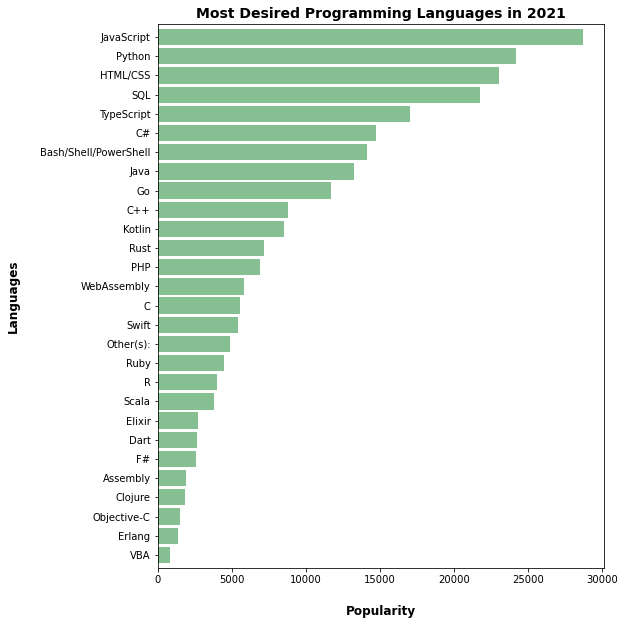

In [7]:
#plotting the graph for the most desired programming languages in 2021
make_graphs('LanguageDesireNextYear')

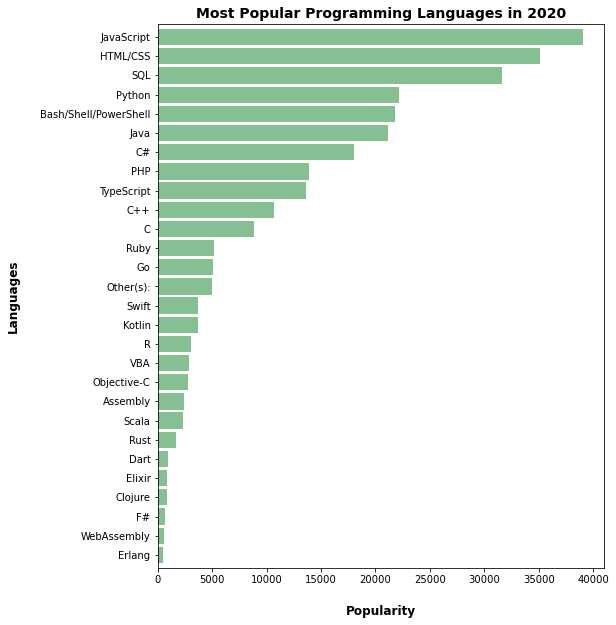

In [8]:
#plotting the graph for the most desired programming languages in 2020
make_graphs('LanguageWorkedWith')

# Part 2 Regression

In [9]:
def get_languages(df):
    '''
    INPUT:
    df - the original dataframe is passed in as input.  
    OUTPUT:
    Outputs all the dummy variables for all the programming languages in the answers.
    
    This function takes in the original dataframe and calculates 1 if a developer konws a particular programming language
    and 0 otherwise for that language. Finally the dataframe with dummy variables is returned as output.

    '''
    df = df.copy()
    df.dropna(axis=0,subset=['LanguageWorkedWith'],how='any',inplace = True)
    language_ranks = df['LanguageWorkedWith'].str.split(';', expand=True).stack().value_counts()
    languages = list(language_ranks.index)
    df['NumberofLanguages'] = df['LanguageWorkedWith'].str.split(';').apply(len)
    for language in languages:
        df[f'Knows_{language}'] = np.where(df['LanguageWorkedWith'].str.find(language) != -1,1,0)
    cols = [col for col in df.columns if 'Knows' in col]  
    cols.extend(['NumberofLanguages','ConvertedComp'])
    return df[cols] 

In [10]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df


In [12]:
#Dividing the dataset into test and training sets, fitting the model and finally predict the results
df_final = get_languages(df)
X = df_final.drop('ConvertedComp',axis=1)
y = df_final['ConvertedComp']
lm_model = LinearRegression(normalize=True)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42)
lm_model.fit(X_train,y_train)
y_preds = lm_model.predict(X_test)

#Use the function to plot top variables based on coefficients
coef_df = coef_weights(lm_model.coef_, X_train)
#A quick look at the top results
coef_df.head(5)

,est_int,coefs,abs_coefs
24,Knows_Clojure,52529.070922,52529.070922
25,Knows_F#,49867.943673,49867.943673
12,Knows_Go,40336.980654,40336.980654
4,Knows_Bash/Shell/PowerShell,33824.375640,33824.375640
20,Knows_Scala,33436.851439,33436.851439
